In [91]:
# Required libraries
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import GridSearchCV

In [8]:
# Загрузим датасет
df = pd.read_csv('../datasets/ILPD/Indian_Liver_Patient_Data_preprocessed.csv')

In [9]:
df.head()

Unnamed: 0  Age    TB   DB  Alkphos  Sgpt  Sgot   TP  ALB    AG  Disease  \
0           0   62  10.9  5.5      699    64   100  7.5  3.2  0.74        1   
1           1   62   7.3  4.1      490    60    68  7.0  3.3  0.89        1   
2           2   58   1.0  0.4      182    14    20  6.8  3.4  1.00        1   
3           3   72   3.9  2.0      195    27    59  7.3  2.4  0.40        1   
4           4   46   1.8  0.7      208    19    14  7.6  4.4  1.30        1   

   g_Female  g_Male  
0         0       1  
1         0       1  
2         0       1  
3         0       1  
4         0       1

In [10]:
df = df.drop(['Unnamed: 0'], axis=1)
df

Age    TB   DB  Alkphos  Sgpt  Sgot   TP  ALB    AG  Disease  g_Female  \
0     62  10.9  5.5      699    64   100  7.5  3.2  0.74        1         0   
1     62   7.3  4.1      490    60    68  7.0  3.3  0.89        1         0   
2     58   1.0  0.4      182    14    20  6.8  3.4  1.00        1         0   
3     72   3.9  2.0      195    27    59  7.3  2.4  0.40        1         0   
4     46   1.8  0.7      208    19    14  7.6  4.4  1.30        1         0   
..   ...   ...  ...      ...   ...   ...  ...  ...   ...      ...       ...   
573   60   0.5  0.1      500    20    34  5.9  1.6  0.37        0         0   
574   40   0.6  0.1       98    35    31  6.0  3.2  1.10        1         0   
575   52   0.8  0.2      245    48    49  6.4  3.2  1.00        1         0   
576   31   1.3  0.5      184    29    32  6.8  3.4  1.00        1         0   
577   38   1.0  0.3      216    21    24  7.3  4.4  1.50        0         0   

     g_Male  
0         1  
1         1  
2         1  
3         1  
4         1  
..      ...  
573       1  
574       1  
575       1  
576       1  
577       1  

[578 rows x 12 columns]

Разделим датафрейм на множество объектов и ответов

In [14]:
X = df.iloc[:, :-3]
X_add = df.iloc[:, -2:]
X = np.hstack((X, X_add))
y = df.iloc[:, 9]

Разделим выборку на обучение и тест

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

Масштабируем

In [19]:
from sklearn.preprocessing import StandardScaler

scaller = StandardScaler().fit(X_train)
X_train = scaller.transform(X_train)
X_test  = scaller.transform(X_test)

## K-nearest neighbors

обучим алгоритм, подберём параметры

In [102]:
from sklearn.neighbors import KNeighborsClassifier

parameters = {'n_neighbors':[1, 2, 3, 4, 5], 'p':[1, 2], 'metric':['braycurtis', 'canberra', 'correlation', 'dice', 'minkowski']}
neighbors_clf = GridSearchCV(KNeighborsClassifier(), parameters, cv=3, verbose=1).fit(X_train, y_train)
neighbors_clf.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


{'metric': 'correlation', 'n_neighbors': 3, 'p': 1}

Посмотрим на эффективность алгоритма

In [96]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = neighbors_clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[16 32]
 [37 89]]
              precision    recall  f1-score   support

           0       0.30      0.33      0.32        48
           1       0.74      0.71      0.72       126

    accuracy                           0.60       174
   macro avg       0.52      0.52      0.52       174
weighted avg       0.62      0.60      0.61       174



Видно, что алгоритм старается избежать ответов где больной является не больным

## DecisionTree

In [103]:
from sklearn import tree
parameters = {'criterion':['gini', 'entropy'], 'min_samples_split':range(1,10), 'min_samples_leaf':range(1,5)}
tree_clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, cv=3, verbose=1).fit(X_train, y_train)
tree_clf.best_params_

Fitting 3 folds for each of 72 candidates, totalling 216 fits


{'criterion': 'gini', 'min_samples_leaf': 4, 'min_samples_split': 5}

In [104]:
y_pred = tree_clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[22 26]
 [28 98]]
              precision    recall  f1-score   support

           0       0.44      0.46      0.45        48
           1       0.79      0.78      0.78       126

    accuracy                           0.69       174
   macro avg       0.62      0.62      0.62       174
weighted avg       0.69      0.69      0.69       174



В данном случае алгоритм эффективнее оценивает, что заметно по метрике f1

Построим граф дерева решений

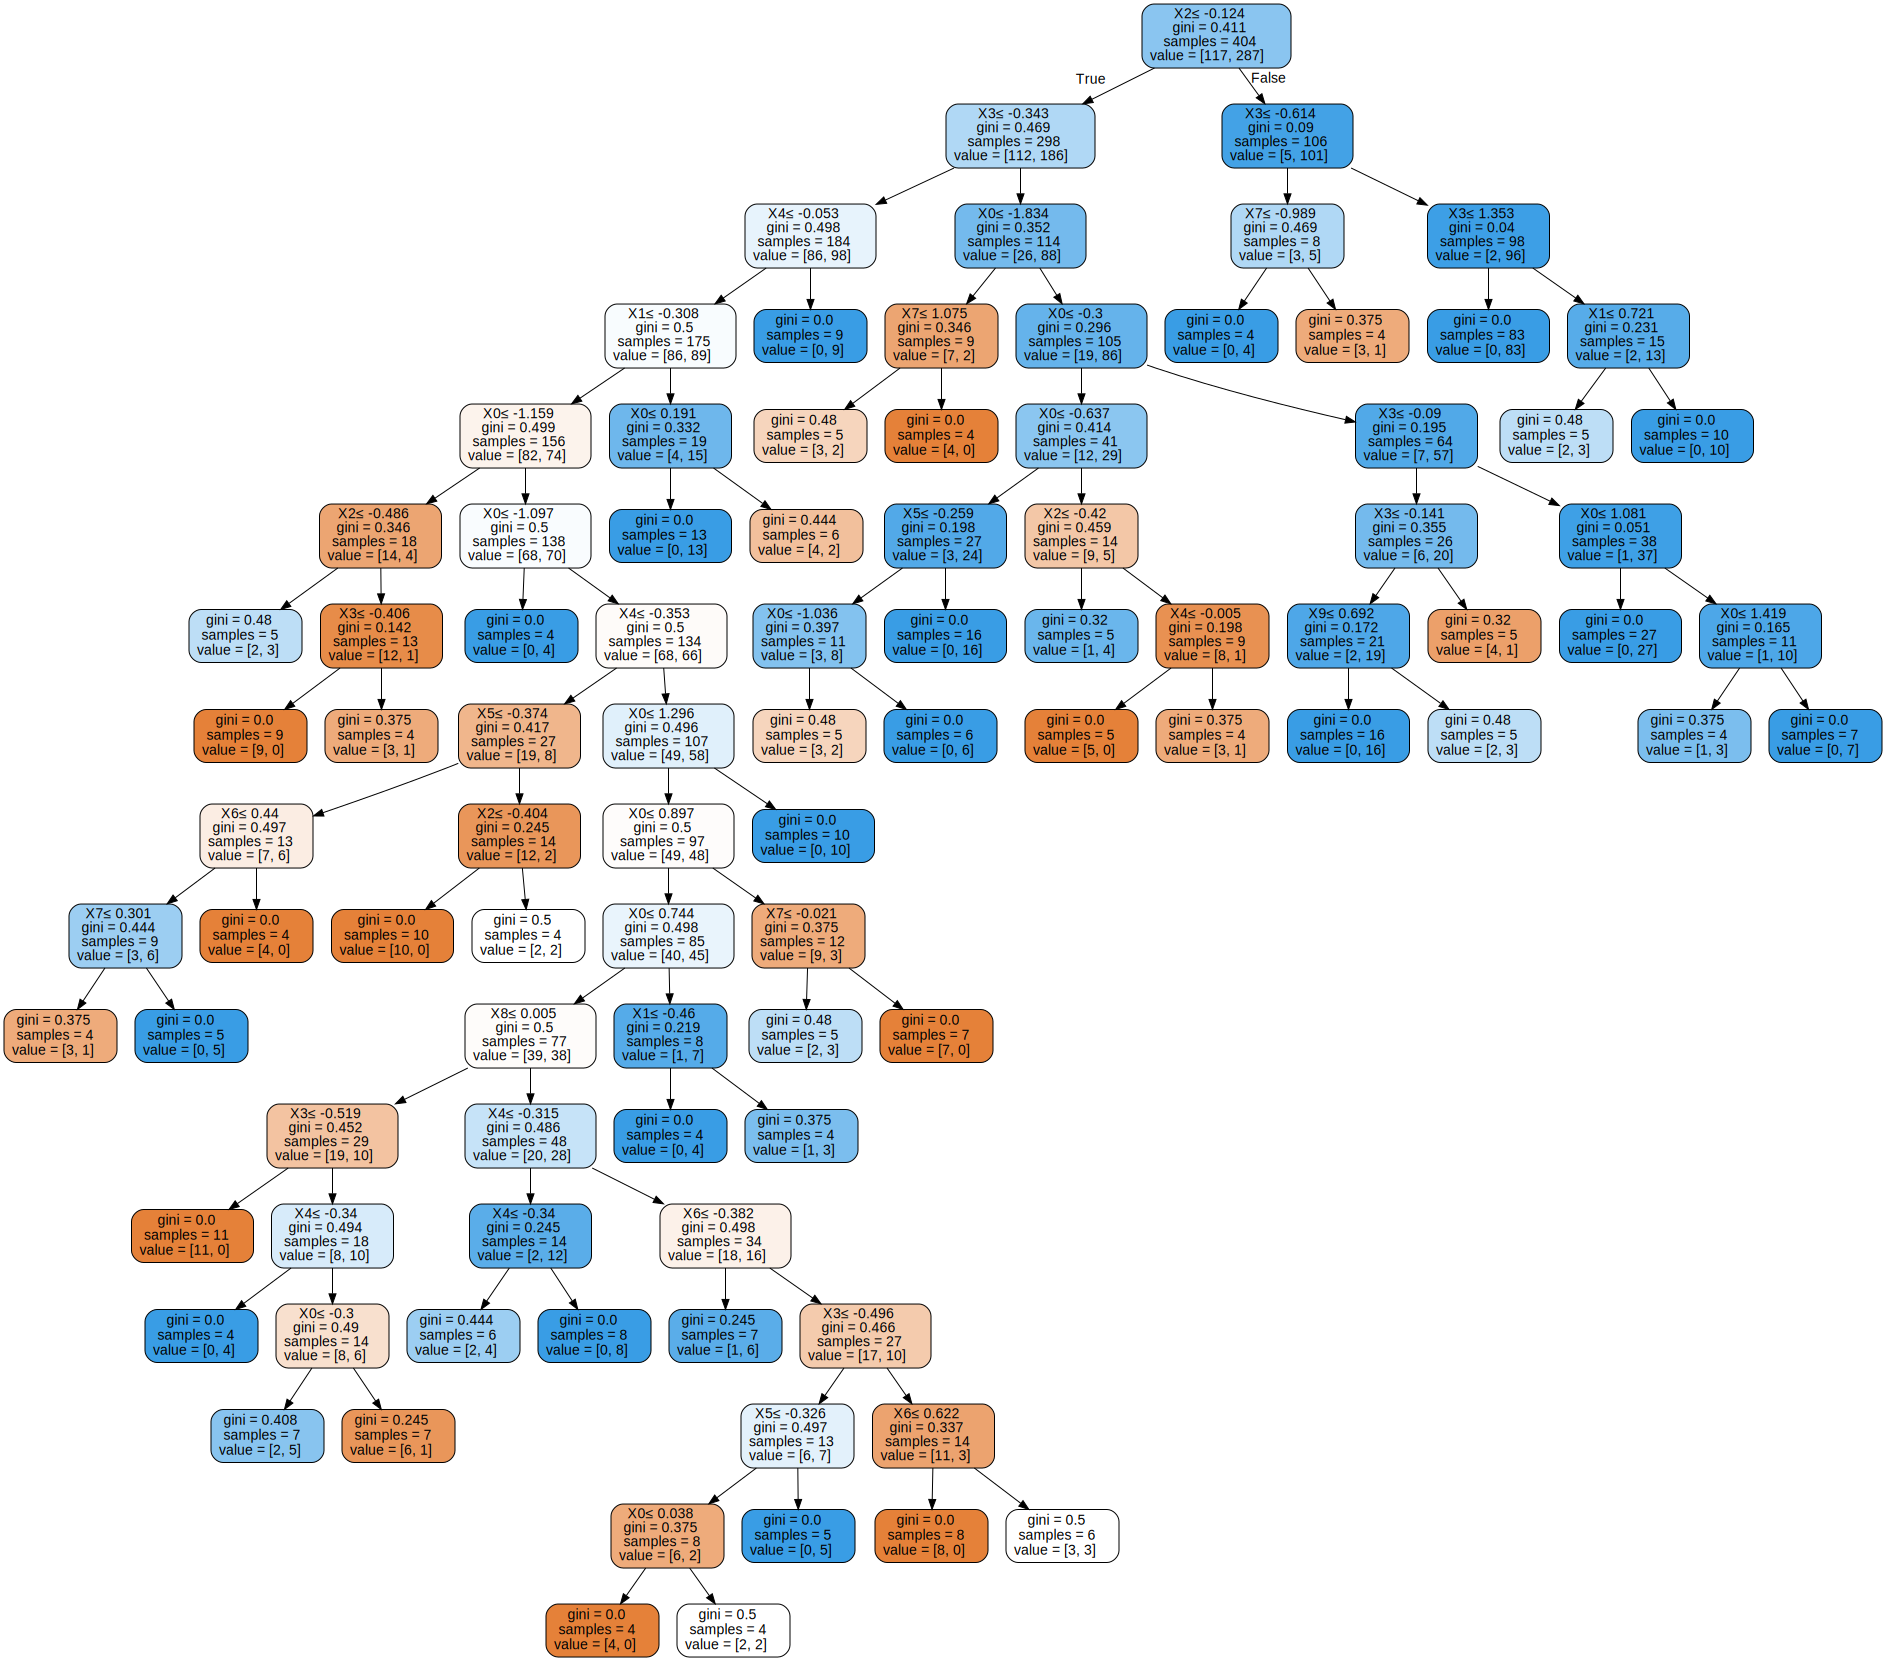

In [106]:
import graphviz

dot_data = tree.export_graphviz(tree_clf.best_estimator_, out_file=None, filled=True, rounded=True, special_characters=True) 
graph = graphviz.Source(dot_data)
graph = graphviz.Source(dot_data)  
graph 

## GaussianNB

Наивный байесовский классификатор

In [112]:
from sklearn.naive_bayes import GaussianNB
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
gaussian_clf = GridSearchCV(GaussianNB(), param_grid=params_NB, cv=3, scoring='accuracy', verbose=1).fit(X_train, y_train)
gaussian_clf.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'var_smoothing': 0.01}

In [113]:
y_pred = gaussian_clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[47  1]
 [77 49]]
              precision    recall  f1-score   support

           0       0.38      0.98      0.55        48
           1       0.98      0.39      0.56       126

    accuracy                           0.55       174
   macro avg       0.68      0.68      0.55       174
weighted avg       0.81      0.55      0.55       174



Данный алгоритм не подходит, так как оценка полноты для больных говорит о неэффективности метода

## Support Vector Machine

Метод опорных векторов

In [116]:
from sklearn import svm
params_svm = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
svm_clf = GridSearchCV(svm.SVC(), param_grid=params_svm, cv=3, scoring='accuracy', verbose=1, refit=True).fit(X_train, y_train)
svm_clf.best_params_

Fitting 3 folds for each of 25 candidates, totalling 75 fits


{'C': 1, 'gamma': 1, 'kernel': 'rbf'}

In [117]:
y_pred = svm_clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 10  38]
 [ 13 113]]
              precision    recall  f1-score   support

           0       0.43      0.21      0.28        48
           1       0.75      0.90      0.82       126

    accuracy                           0.71       174
   macro avg       0.59      0.55      0.55       174
weighted avg       0.66      0.71      0.67       174



Метод хорошо выделяет больных из выборки, но недостаточно хорошо угадывает больных

## Logistic Regression

Метод логистической регрессии

In [123]:
from sklearn.linear_model import LogisticRegression

params_LR = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
LR_clf = GridSearchCV(LogisticRegression(), param_grid=params_LR, cv=3, scoring='accuracy', verbose=1, refit=True).fit(X_train, y_train)
LR_clf.best_params_

Fitting 3 folds for each of 14 candidates, totalling 42 fits


{'C': 100.0, 'penalty': 'l2'}

In [124]:
y_pred = LR_clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 15  33]
 [ 20 106]]
              precision    recall  f1-score   support

           0       0.43      0.31      0.36        48
           1       0.76      0.84      0.80       126

    accuracy                           0.70       174
   macro avg       0.60      0.58      0.58       174
weighted avg       0.67      0.70      0.68       174

